## Intelligent Image Classification System with Deep Learning

#### Import Libraries & Suppress Warnings

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gradio as gr
import warnings, os, tensorflow as tf

warnings.filterwarnings("ignore", message="`input_shape` is undefined or non-square")
warnings.filterwarnings("ignore", message="The structure of `inputs`")
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

#### GPU check

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[]


#### Define dataset directory

In [3]:
data_dir = 'data'   # structure: data/Class1, data/Class2
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#### Clean images with invalid format

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Removing invalid: {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with {image_path}: {e}')

#### Create image dataset

In [5]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir, image_size=(256, 256), batch_size=32
)

Found 400 files belonging to 2 classes.


#### Display sample images

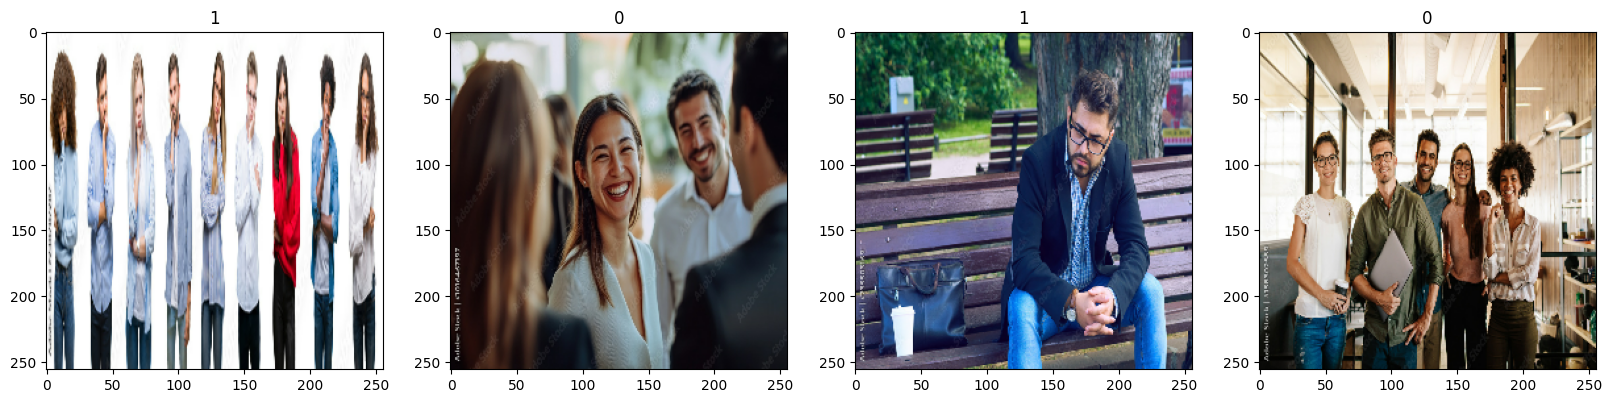

In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # FIX: remove .numpy() since it's already numpy
    ax[idx].set_title(str(batch[1][idx]))
plt.show()

#### Normalize dataset

In [7]:
data = data.map(lambda x, y: (x/255, y))

#### Split dataset

In [8]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#### Class names

In [9]:
class_names = os.listdir(data_dir)
print("Classes:", class_names)

Classes: ['happy', 'sad']


#### Visualize training batches

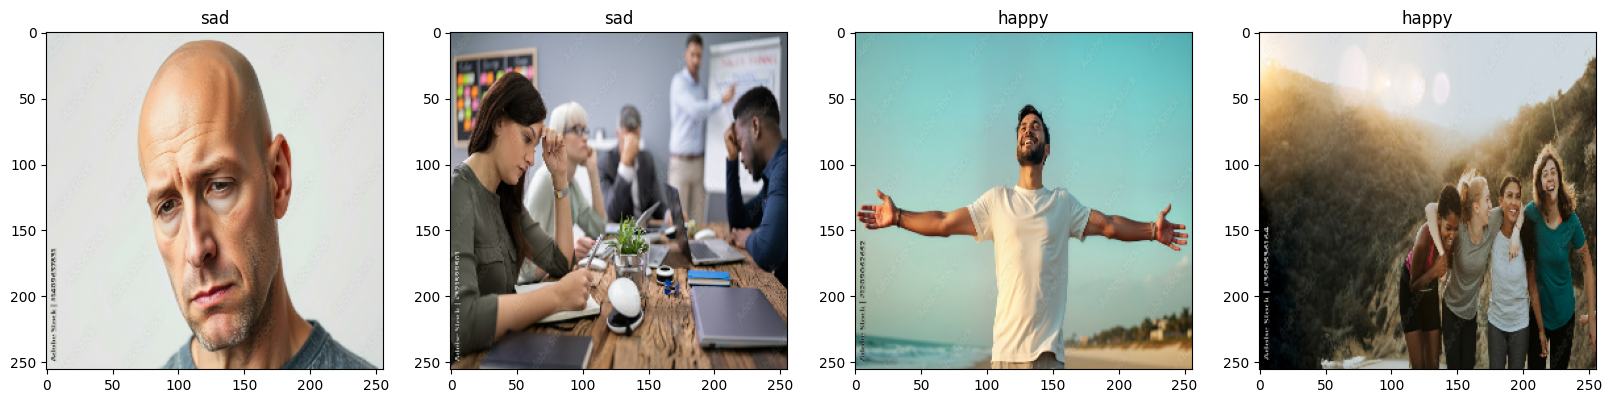

In [10]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx]])
plt.show()

#### Augmentation & preprocess helpers

In [11]:
from tensorflow.keras import layers, models, callbacks
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
], name='data_augmentation')

def preprocess_for_training(ds):
    return ds.map(lambda x, y: (x, y), num_parallel_calls=AUTOTUNE)

train = train.map(lambda x,y: (x, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val = val.cache().prefetch(AUTOTUNE)
test = test.cache().prefetch(AUTOTUNE)

#### Build Model 1: Baseline Custom CNN (sigmoid output for binary)

In [12]:
def build_baseline_cnn(input_shape=(256,256,3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='BaselineCNN')
    return model

baseline = build_baseline_cnn()
baseline.summary()

Model: "BaselineCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,449 (32.09 MB)

 Trainable params: 8,412,449 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile & Train Baseline CNN

In [13]:
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cb_baseline = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint('saved_models/baseline_cnn_best.keras', save_best_only=True)
]
hist_baseline = baseline.fit(train, validation_data=val, epochs=12, callbacks=cb_baseline)

Epoch 1/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - accuracy: 0.5098 - loss: 1.7817 - val_accuracy: 0.4844 - val_loss: 0.7431
Epoch 2/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 660ms/step - accuracy: 0.4996 - loss: 0.7122 - val_accuracy: 0.5156 - val_loss: 0.6857
Epoch 3/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 652ms/step - accuracy: 0.5385 - loss: 0.6884 - val_accuracy: 0.6094 - val_loss: 0.6338
Epoch 4/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step - accuracy: 0.6434 - loss: 0.6688 - val_accuracy: 0.6250 - val_loss: 0.6580
Epoch 5/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.5913 - loss: 0.6709 - val_accuracy: 0.5469 - val_loss: 0.6578
Epoch 6/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 694ms/step - accuracy: 0.5811 - loss: 0.6559 - val_accuracy: 0.6094 - val_loss: 0.6117
Epoch 7/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 691ms/step - accuracy: 0.6704 - loss: 0.6231 - val_accuracy: 0.6406 - val_loss: 0.5889
Epoch 8/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.6738 - loss: 0.6196 - val_accuracy: 0.6406 - val_loss

#### Plot Baseline training curves

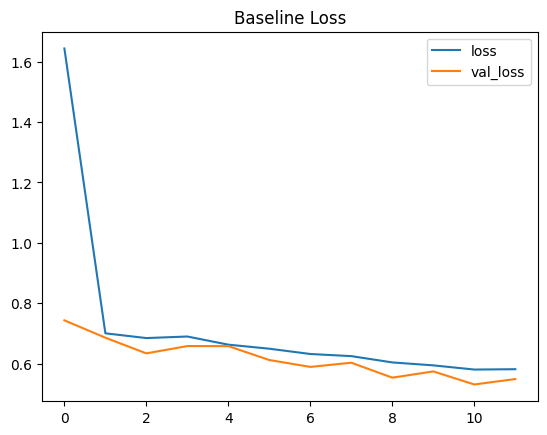

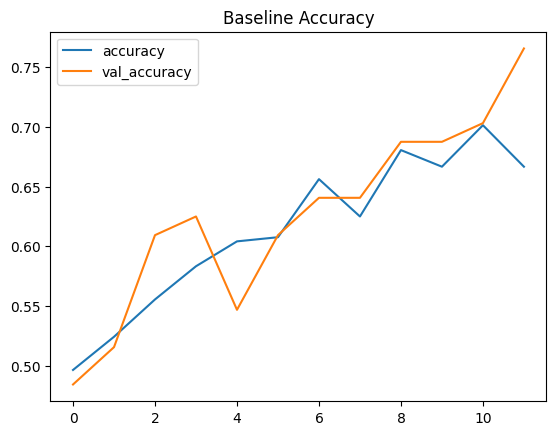

In [14]:
plt.figure(); plt.plot(hist_baseline.history['loss'], label='loss'); plt.plot(hist_baseline.history['val_loss'], label='val_loss')
plt.title('Baseline Loss'); plt.legend(); plt.show()

plt.figure(); plt.plot(hist_baseline.history['accuracy'], label='accuracy'); plt.plot(hist_baseline.history['val_accuracy'], label='val_accuracy')
plt.title('Baseline Accuracy'); plt.legend(); plt.show()

#### Evaluate Baseline & compute metrics (precision/recall/f1)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

baseline_eval = baseline.evaluate(test, return_dict=True)
print("Baseline eval:", baseline_eval)

# Collect predictions for detailed metrics
y_true_b, y_pred_b = [], []
for Xb, yb in test:
    preds = baseline.predict(Xb).ravel()
    y_true_b.extend(yb.numpy().tolist())
    y_pred_b.extend((preds > 0.5).astype(int).tolist())

y_true_b = np.array(y_true_b); y_pred_b = np.array(y_pred_b)
print("Precision:", precision_score(y_true_b, y_pred_b, zero_division=0))
print("Recall:", recall_score(y_true_b, y_pred_b, zero_division=0))
print("F1:", f1_score(y_true_b, y_pred_b, zero_division=0))
print("Confusion Matrix:\\n", confusion_matrix(y_true_b, y_pred_b))
print(classification_report(y_true_b, y_pred_b, target_names=class_names, zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step - accuracy: 0.7188 - loss: 0.5397
Baseline eval: {'accuracy': 0.71875, 'loss': 0.5397241115570068}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Precision: 0.7777777777777778
Recall: 0.7368421052631579
F1: 0.7567567567567568
Confusion Matrix:\n [[ 9  4]
 [ 5 14]]
              precision    recall  f1-score   support

       happy       0.64      0.69      0.67        13
         sad       0.78      0.74      0.76        19

    accuracy                           0.72        32
   macro avg       0.71      0.71      0.71        32
weighted avg       0.72      0.72      0.72        32



#### Save Baseline final model

In [16]:
os.makedirs('saved_models', exist_ok=True)
baseline.save('saved_models/baseline_cnn_final.keras')
print("Saved baseline model to saved_models/baseline_cnn_final.keras")

Saved baseline model to saved_models/baseline_cnn_final.keras


#### Build Model 2: Deep CNN (BatchNorm + Dropout)

In [17]:
def build_deep_cnn(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    for filters in (32, 64, 128):
        x = layers.Conv2D(filters, 3, padding='same', activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs, name='DeepCNN')

deep_cnn = build_deep_cnn()
deep_cnn.summary()

Model: "DeepCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 322,081 (1.23 MB)

 Trainable params: 321,185 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

#### Compile & Train Deep CNN

In [18]:
deep_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cb_deep = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint('saved_models/deep_cnn_best.keras', save_best_only=True)
]
hist_deep = deep_cnn.fit(train, validation_data=val, epochs=12, callbacks=cb_deep)

Epoch 1/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 9s/step - accuracy: 0.5865 - loss: 0.7547 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.5511 - loss: 0.6901 - val_accuracy: 0.5625 - val_loss: 0.6872
Epoch 3/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.6804 - loss: 0.5945 - val_accuracy: 0.5312 - val_loss: 0.6800
Epoch 4/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.6469 - loss: 0.6489 - val_accuracy: 0.5312 - val_loss: 0.6830
Epoch 5/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.6667 - loss: 0.5995 - val_accuracy: 0.5625 - val_loss: 0.6797
Epoch 6/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 89s 10s/step - accuracy: 0.6716 - loss: 0.5933 - val_accuracy: 0.6250 - val_loss: 0.6814
Epoch 7/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 109s 12s/step - accuracy: 0.6779 - loss: 0.6216 - val_accuracy: 0.4844 - val_loss: 0.6877
Epoch 8/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 89s 10s/step - accuracy: 0.7175 - loss: 0.5610 - val_accuracy: 0.4844 - val_loss: 0.6778
Epoc

#### Plot Deep CNN training curves & evaluate

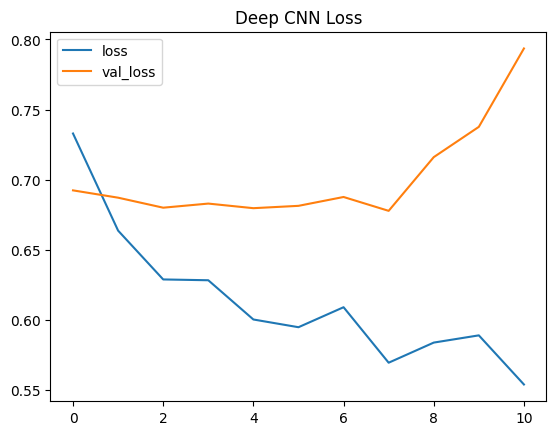

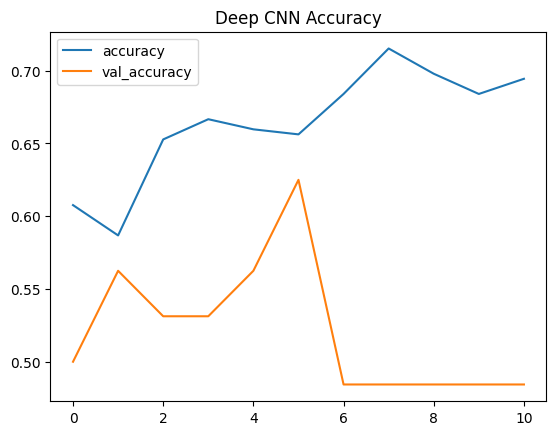

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.6374
Deep CNN eval: {'accuracy': 0.65625, 'loss': 0.6373679637908936}


In [19]:
plt.figure(); plt.plot(hist_deep.history['loss'], label='loss'); plt.plot(hist_deep.history['val_loss'], label='val_loss')
plt.title('Deep CNN Loss'); plt.legend(); plt.show()

plt.figure(); plt.plot(hist_deep.history['accuracy'], label='accuracy'); plt.plot(hist_deep.history['val_accuracy'], label='val_accuracy')
plt.title('Deep CNN Accuracy'); plt.legend(); plt.show()

deep_eval = deep_cnn.evaluate(test, return_dict=True)
print("Deep CNN eval:", deep_eval)

#### Deep CNN detailed metrics & save

In [20]:
y_true_d, y_pred_d = [], []
for Xb, yb in test:
    preds = deep_cnn.predict(Xb).ravel()
    y_true_d.extend(yb.numpy().tolist())
    y_pred_d.extend((preds > 0.5).astype(int).tolist())

y_true_d = np.array(y_true_d); y_pred_d = np.array(y_pred_d)
print("Deep Precision:", precision_score(y_true_d, y_pred_d, zero_division=0))
print("Deep Recall:", recall_score(y_true_d, y_pred_d, zero_division=0))
print("Deep F1:", f1_score(y_true_d, y_pred_d, zero_division=0))
print("Deep Confusion Matrix:\\n", confusion_matrix(y_true_d, y_pred_d))

deep_cnn.save('saved_models/deep_cnn_final.keras')
print("Saved deep cnn to saved_models/deep_cnn_final.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Deep Precision: 0.6333333333333333
Deep Recall: 1.0
Deep F1: 0.7755102040816326
Deep Confusion Matrix:\n [[ 2 11]
 [ 0 19]]
Saved deep cnn to saved_models/deep_cnn_final.keras


#### Build Model 3: MobileNetV2 Transfer Learning (frozen base)

In [21]:
from tensorflow.keras import applications

def build_mobilenet_tl(input_shape=(256,256,3)):
    base = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # we normalized to [0,1]; MobileNet preprocess expects inputs scaled appropriately:
    x = applications.mobilenet_v2.preprocess_input(x * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name='MobileNetV2_TL')
    return model

mobilenet = build_mobilenet_tl()
mobilenet.summary()

Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Compile & Train MobileNetV2 (frozen base)

In [22]:

mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cb_m = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint('saved_models/mobilenet_best.keras', save_best_only=True)
]
hist_mobilenet = mobilenet.fit(train, validation_data=val, epochs=12, callbacks=cb_m)

Epoch 1/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5262 - loss: 0.9951 - val_accuracy: 0.5469 - val_loss: 0.7472
Epoch 2/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5753 - loss: 0.7167 - val_accuracy: 0.7500 - val_loss: 0.5404
Epoch 3/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7711 - loss: 0.5107 - val_accuracy: 0.8750 - val_loss: 0.4309
Epoch 4/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7745 - loss: 0.4590 - val_accuracy: 0.8750 - val_loss: 0.3756
Epoch 5/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8176 - loss: 0.4387 - val_accuracy: 0.7656 - val_loss: 0.4424
Epoch 6/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8396 - loss: 0.3954 - val_accuracy: 0.8438 - val_loss: 0.3382
Epoch 7/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8676 - loss: 0.3828 - val_accuracy: 0.8438 - val_loss: 0.3001
Epoch 8/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8247 - loss: 0.3668 - val_accuracy: 0.9062 - val_loss: 0.2890
Epoch 9/

#### Plot MobileNet training curves

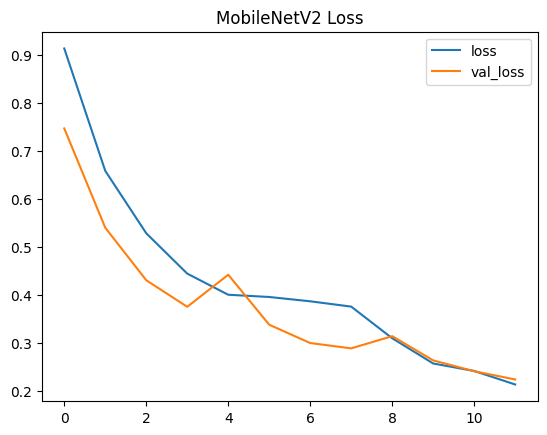

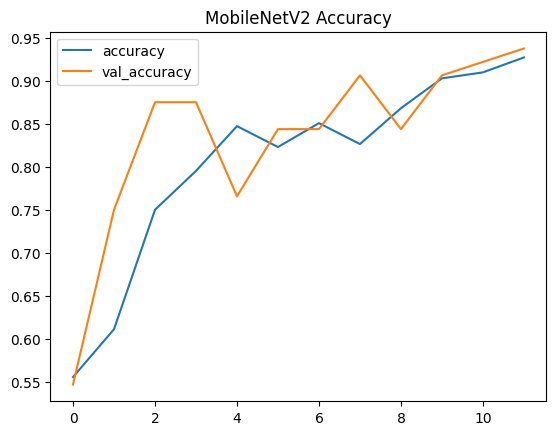

In [23]:
plt.figure(); plt.plot(hist_mobilenet.history['loss'], label='loss'); plt.plot(hist_mobilenet.history['val_loss'], label='val_loss')
plt.title('MobileNetV2 Loss'); plt.legend(); plt.show()

plt.figure(); plt.plot(hist_mobilenet.history['accuracy'], label='accuracy'); plt.plot(hist_mobilenet.history['val_accuracy'], label='val_accuracy')
plt.title('MobileNetV2 Accuracy'); plt.legend(); plt.show()

#### Evaluate MobileNetV2 on test set

In [24]:
m_eval = mobilenet.evaluate(test, return_dict=True)
print("MobileNet eval:", m_eval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9062 - loss: 0.2353
MobileNet eval: {'accuracy': 0.90625, 'loss': 0.23530800640583038}


#### Detailed MobileNet predictions & metrics

In [25]:
y_true_m, y_pred_m = [], []
for Xb, yb in test:
    preds = mobilenet.predict(Xb).ravel()
    y_true_m.extend(yb.numpy().tolist())
    y_pred_m.extend((preds > 0.5).astype(int).tolist())

y_true_m = np.array(y_true_m); y_pred_m = np.array(y_pred_m)
print("MobileNet Precision:", precision_score(y_true_m, y_pred_m, zero_division=0))
print("MobileNet Recall:", recall_score(y_true_m, y_pred_m, zero_division=0))
print("MobileNet F1:", f1_score(y_true_m, y_pred_m, zero_division=0))
print("MobileNet Confusion Matrix:\\n", confusion_matrix(y_true_m, y_pred_m))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
MobileNet Precision: 0.8636363636363636
MobileNet Recall: 1.0
MobileNet F1: 0.926829268292683
MobileNet Confusion Matrix:\n [[10  3]
 [ 0 19]]


#### Save MobileNet final model

In [26]:
mobilenet.save('saved_models/mobilenet_v2_final.keras')
print("Saved MobileNet to saved_models/mobilenet_v2_final.keras")

Saved MobileNet to saved_models/mobilenet_v2_final.keras


#### Aggregate metrics from all models

In [27]:
metrics_summary = {
    'baseline': {
        'eval': baseline_eval,
        'precision': float(precision_score(y_true_b, y_pred_b, zero_division=0)),
        'recall': float(recall_score(y_true_b, y_pred_b, zero_division=0)),
        'f1': float(f1_score(y_true_b, y_pred_b, zero_division=0))
    },
    'deep_cnn': {
        'eval': deep_eval,
        'precision': float(precision_score(y_true_d, y_pred_d, zero_division=0)),
        'recall': float(recall_score(y_true_d, y_pred_d, zero_division=0)),
        'f1': float(f1_score(y_true_d, y_pred_d, zero_division=0))
    },
    'mobilenet_v2': {
        'eval': m_eval,
        'precision': float(precision_score(y_true_m, y_pred_m, zero_division=0)),
        'recall': float(recall_score(y_true_m, y_pred_m, zero_division=0)),
        'f1': float(f1_score(y_true_m, y_pred_m, zero_division=0))
    }
}
import json
with open('metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)
print("Saved metrics_summary.json")

Saved metrics_summary.json


#### Plot comparison: accuracy & F1

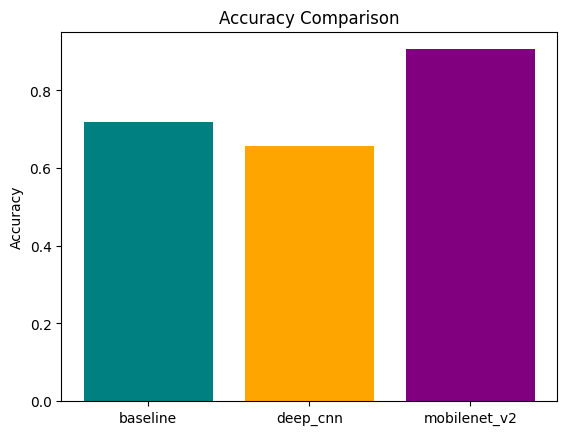

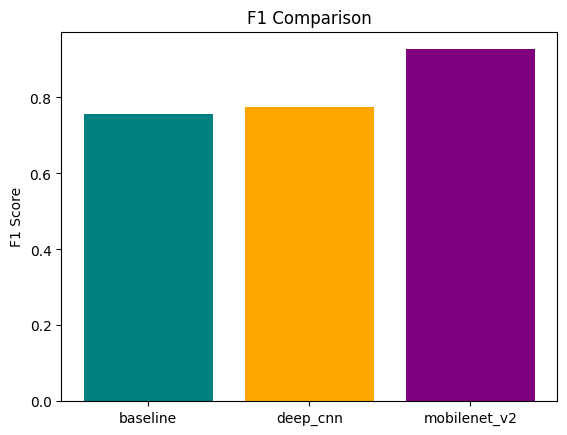

In [28]:
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

labels = ['baseline', 'deep_cnn', 'mobilenet_v2']
accs = [
    float(baseline_eval.get('accuracy', 0.0)),
    float(deep_eval.get('accuracy', 0.0)),
    float(m_eval.get('accuracy', 0.0))
]
f1s = [metrics_summary[l]['f1'] for l in labels]

# Accuracy plot
plt.figure()
plt.bar(labels, accs, color=["teal", "orange", "purple"])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(PLOTS_DIR, 'compare_accuracy.png'))
plt.show()

# F1 plot
plt.figure()
plt.bar(labels, f1s, color=["teal", "orange", "purple"])
plt.title('F1 Comparison')
plt.ylabel('F1 Score')
plt.savefig(os.path.join(PLOTS_DIR, 'compare_f1.png'))
plt.show()

#### Show confusion matrices for each model (visual)

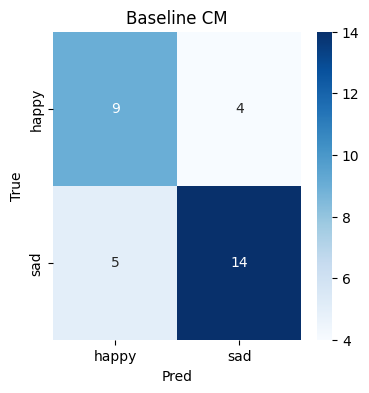

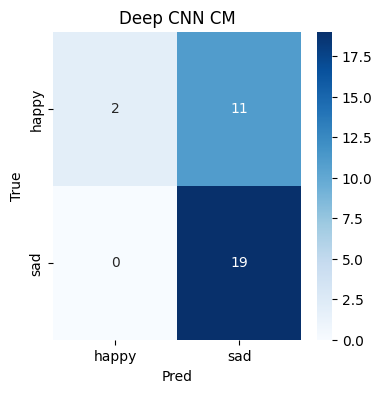

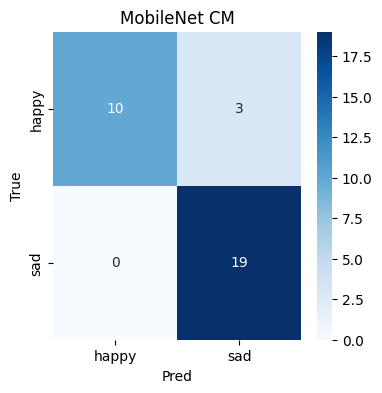

In [29]:
def show_cm(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.show()

show_cm(confusion_matrix(y_true_b, y_pred_b), 'Baseline CM')
show_cm(confusion_matrix(y_true_d, y_pred_d), 'Deep CNN CM')
show_cm(confusion_matrix(y_true_m, y_pred_m), 'MobileNet CM')

#### List saved models & files

In [30]:
print("Saved models folder contents:")
for f in sorted(os.listdir('saved_models')):
    print('-', f)
print("Plots saved to:", PLOTS_DIR)

Saved models folder contents:
- baseline_cnn_best.keras
- baseline_cnn_final.keras
- deep_cnn_best.keras
- deep_cnn_final.keras
- mobilenet_best.keras
- mobilenet_v2_final.keras
Plots saved to: plots


#### Import Grad-CAM requirements

In [31]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm

#### Grad-CAM utility function

In [32]:
def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#### Function to overlay heatmap on image

In [33]:
def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = cv2.addWeighted(img, 1-alpha, jet_heatmap, alpha, 0)
    return superimposed_img

#### Quick test of Grad-CAM on a single test image (Deep CNN)

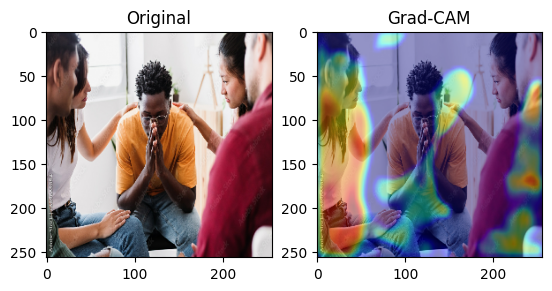

In [34]:
for Xb, yb in test.take(1):
    img = Xb[0].numpy()
    img_input = np.expand_dims(img, axis=0)

    # Use the deepest conv layer from your model
    heatmap = get_gradcam_heatmap(img_input, deep_cnn, last_conv_layer_name="conv2d_8")

    cam_img = overlay_gradcam((img*255).astype("uint8"), heatmap)
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(cam_img); plt.title("Grad-CAM")
    plt.show()
    break

#### Create helper: preprocess image for inference

In [35]:
def preprocess_image(img, target_size=(256,256)):
    img_resized = tf.image.resize(img, target_size)
    img_array = np.expand_dims(img_resized/255.0, axis=0)
    return img_array

#### Helper: predict class with selected model

In [36]:
def predict_image(img, model, threshold=0.5):
    img_array = preprocess_image(img)
    pred = model.predict(img_array)[0][0]
    label = class_names[int(pred > threshold)]
    confidence = float(pred if pred>threshold else 1-pred)
    return label, confidence

#### Function to generate Grad-CAM for Gradio interface

In [37]:
def generate_gradcam(img, model, last_conv_layer="conv5_block3_out"):
    img_array = preprocess_image(img)
    heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer)
    overlay = overlay_gradcam((img*255).astype("uint8"), heatmap)
    return overlay

#### Dictionary to load models dynamically for Gradio

In [38]:
MODEL_PATHS = {
    "Baseline CNN": "saved_models/baseline_cnn_final.keras",
    "Deep CNN": "saved_models/deep_cnn_final.keras",
    "MobileNetV2": "saved_models/mobilenet_v2_final.keras"
}

def load_model_choice(choice):
    return tf.keras.models.load_model(MODEL_PATHS[choice], compile=False)

#### Function that ties everything (prediction + Grad-CAM)

In [39]:
def classify_with_gradcam(img, model_name):
    # Resize to the same shape as training
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    if model_name == "Simple CNN":
        model = simple_cnn
        last_layer = "conv2d_2"
    elif model_name == "Deep CNN":
        model = deep_cnn
        last_layer = "conv2d_8"
    else:
        return "Invalid model", img

    preds = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_class = class_names[pred_idx]

    # Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(img_input, model, last_layer)
    cam_img = overlay_gradcam((img_resized*255).astype("uint8"), heatmap)

    cam_img = np.array(cam_img, dtype=np.uint8)

    return pred_class, cam_img

#### Sanity check before Gradio

Prediction: happy


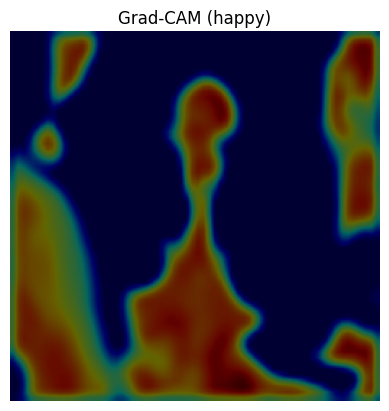

In [40]:
for Xb, yb in test.take(1):
    result, cam = classify_with_gradcam(Xb[0].numpy(), "Deep CNN")
    print("Prediction:", result)
    plt.imshow(cam)
    plt.title(f"Grad-CAM ({result})")
    plt.axis("off")
    plt.show()
    break

#### Helper: find last conv layer (robust)

In [41]:
def find_last_conv_layer_name(model):
    # Return name of last Conv2D layer if present, else None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        # some TF apps use layers with 'conv' in name but not Conv2D class
        if 'conv' in layer.name.lower():
            return layer.name
    return None

#### Cached model loader (avoid repeated loads)

In [42]:
_MODEL_CACHE = {}
def load_model_cached(name):
    if name in _MODEL_CACHE:
        return _MODEL_CACHE[name]
    path = MODEL_PATHS.get(name) if 'MODEL_PATHS' in globals() else None
    if path is None:
        # try common filenames
        candidates = {
            "Baseline CNN": "saved_models/baseline_cnn_final.keras",
            "Deep CNN": "saved_models/deep_cnn_final.keras",
            "MobileNetV2": "saved_models/mobilenet_v2_final.keras"
        }
        path = candidates.get(name)
    if path is None or not os.path.exists(path):
        raise FileNotFoundError(f"Model file for '{name}' not found at '{path}'")
    model = tf.keras.models.load_model(path, compile=False)
    _MODEL_CACHE[name] = model
    return model

#### Inference function (returns probs dict and predicted label)

In [43]:
IMG_SIZE = (256, 256)

# Auto-detect sigmoid vs softmax output
def predict_with_model_numpy(img_np, model):
    """
    img_np: H,W,3 numpy with values in 0..255 or 0..1
    model: trained keras model
    
    Returns:
        probs (dict): {class_name: probability}
        pred_label (str): predicted class
        conf (float): confidence of predicted class
    """
    # Resize & normalize
    arr = img_np.astype('float32')
    if arr.max() > 1.0:
        arr = arr / 255.0
    arr = tf.image.resize(arr, IMG_SIZE).numpy()
    batch = np.expand_dims(arr, 0)
    out = model.predict(batch, verbose=0)[0]

    # Case 1: Binary classifier (sigmoid → single output value)
    if len(out.shape) == 0 or out.shape == ():
        prob1 = float(out)
        prob0 = 1.0 - prob1
        probs = {class_names[0]: round(prob0, 4), class_names[1]: round(prob1, 4)}
        pred_label = class_names[int(prob1 > 0.5)]
        return probs, pred_label, max(prob0, prob1)

    if out.shape[0] == 1:  # shape (1,)
        prob1 = float(out[0])
        prob0 = 1.0 - prob1
        probs = {class_names[0]: round(prob0, 4), class_names[1]: round(prob1, 4)}
        pred_label = class_names[int(prob1 > 0.5)]
        return probs, pred_label, max(prob0, prob1)

    # Case 2: Multi-class classifier (softmax → vector)
    else:
        vec = out
        idx = int(np.argmax(vec))
        probs = {class_names[i]: float(vec[i]) for i in range(len(vec))}
        pred_label = class_names[idx]
        return probs, pred_label, float(vec[idx])

#### Grad-CAM wrapper that finds a suitable conv layer automatically

In [44]:
def gradcam_for_model(img_np, model):
    try:
        arr = img_np.astype('float32')
        if arr.max() > 1.0:
            arr = arr / 255.0
        arr = tf.image.resize(arr, IMG_SIZE).numpy()
        batch = np.expand_dims(arr, 0)
        last_conv = find_last_conv_layer_name(model)
        if last_conv is None:
            raise ValueError("No conv layer found for Grad-CAM")
        heatmap = get_gradcam_heatmap(batch, model, last_conv)
        # overlay and convert to uint8
        overlay = overlay_gradcam((arr*255).astype('uint8'), heatmap)
        return overlay
    except Exception as e:
        # return None if Grad-CAM fails (caller handles it)
        print("Grad-CAM error:", e)
        return None

#### Gradio inference function (model selection + optional gradcam)

In [45]:
def gradio_infer(img, model_name, show_gradcam=False):
    """
    img: input from gradio (PIL or numpy)
    model_name: one of MODEL_PATHS keys (string)
    show_gradcam: bool
    returns: (probs dict, predicted label string, gradcam image or None)
    """
    if img is None:
        return {"error": "no image provided"}, "", None

    # Convert PIL -> numpy if necessary
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Load model (cached)
    model = load_model_cached(model_name)

    # Predict
    probs, pred_label, conf = predict_with_model_numpy(img, model)

    # Optionally compute Grad-CAM
    gradcam_img = None
    if show_gradcam:
        try:
            gradcam_img = gradcam_for_model(img, model)
        except Exception as e:
            print("Could not compute Grad-CAM:", e)
            gradcam_img = None

    return probs, pred_label, gradcam_img

#### Build Gradio Blocks UI components (definition only)

In [46]:
with gr.Blocks() as demo:
    gr.Markdown("# Two-Class Image Classifier — Model Selection")
    with gr.Row():
        with gr.Column(scale=1):
            input_img = gr.Image(type="numpy", label="Upload Image")
            model_sel = gr.Dropdown(choices=list(MODEL_PATHS.keys()) if 'MODEL_PATHS' in globals() else ["Baseline CNN","Deep CNN","MobileNetV2"],
                                    value=(list(MODEL_PATHS.keys())[0] if 'MODEL_PATHS' in globals() else "Baseline CNN"),
                                    label="Select Model")
            gradcam_ck = gr.Checkbox(label="Show Grad-CAM overlay (if available)", value=False)
            predict_btn = gr.Button("Predict")
        with gr.Column(scale=1):
            out_probs = gr.Label(num_top_classes=2, label="Class Probabilities")
            out_label = gr.Textbox(label="Predicted Class")
            out_gradcam = gr.Image(label="Grad-CAM Overlay (if generated)")
    predict_btn.click(fn=gradio_infer, inputs=[input_img, model_sel, gradcam_ck], outputs=[out_probs, out_label, out_gradcam])

#### Print model map so user can verify paths

In [47]:
print("Model files used by Gradio:")
for k,v in (MODEL_PATHS.items() if 'MODEL_PATHS' in globals() else {"Baseline CNN":"saved_models/baseline_cnn_final.keras"}.items()):
    print(f" - {k}: {v} (exists={os.path.exists(v)})")

Model files used by Gradio:
 - Baseline CNN: saved_models/baseline_cnn_final.keras (exists=True)
 - Deep CNN: saved_models/deep_cnn_final.keras (exists=True)
 - MobileNetV2: saved_models/mobilenet_v2_final.keras (exists=True)


#### Quick manual test (if you want to test without launching UI)

In [48]:
import glob

# Use any image path from your data folder for a quick sanity check
sample_img_path = None
for cls in class_names:   
    cand = glob.glob(os.path.join(data_dir, cls, '*'))
    if cand:
        sample_img_path = cand[0]
        break

if sample_img_path:
    from PIL import Image
    test_img = np.array(Image.open(sample_img_path).convert('RGB'))
    try:
        probs, lbl, _ = gradio_infer(test_img, list(MODEL_PATHS.keys())[0], show_gradcam=False)
        print("Sanity test ->", probs, lbl)
    except Exception as e:
        print("Sanity test failed:", e)
else:
    print("No sample image found for quick test.")

Sanity test -> {'happy': 0.9133, 'sad': 0.0867} happy


#### Launch the Gradio interface (this is the last cell)

In [49]:
# It will start the web UI. Change share=True if you want a public link.
demo.launch(share=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
